# Overview
This notebook is a 2 part hands-on demonstration of working with Amazon review data for text analytics. The first part uses LDA and Kmeans algorithms to automatically group together reviews based on topics discussed within the text. The second part covers predicting review scores using SVM and Logistic Regression based on contents of the review. The end shows how to predict the rating of a new review based on the models.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

## Import review data
This dataset was compiled Julian McAuley and can be downloaded here http://jmcauley.ucsd.edu/data/amazon/. The Home & Kitchen data file contains around 551,000 reviews by Amazon customers. We read these into a Pandas dataframe for further analysis.

Amazon reviews can span from 1 star to 5 stars. The difference between a 1-2 or a 4-5 might be very noisy when we build predictions. Instead, we bucket reviews by:
- Low: 1-2 Stars
- Neutral: 3 Stars
- High: 4-5 Stars

Reviews are filtered to those with at least 45 words to avoid short, uninformative reviews like "This is great!". After limiting, we take a stratified sample of 6000 reviews from each bucket to get reasonable performance from sklearn in Python. The stratification helps us overcome the bias in that 80% of the reviews have 4-5 star ratings.

In [21]:
cat = ['low','neutral','high']
def cat_y(y):
    if y<=2.0:
        return cat[0]
    elif y>=4.0:
        return cat[2]
    else:
        return cat[1]

def get_reviews(path, n_samples):
    dt = {}
    i=0
    with open(path) as f:
        for d in f.readlines():
            dt[i] = eval(d)
            i += 1
    df = pd.DataFrame.from_dict(dt, orient='index')[['reviewText','overall']]
    df = df[df['reviewText'].apply(lambda x: len(x.split())>=45)]
    df['bucket'] = df['overall'].apply(cat_y)
    
    df = df.groupby('bucket').apply(lambda x: x.sample(n=n_samples))
    return df

data = get_reviews('Home_and_Kitchen_5.json', 6000)
pd.set_option('display.max_colwidth', -1)
data.sample(4)

,,reviewText,overall,bucket
bucket,,,,
neutral,214120,"BAGGU bags are made of 100% Ripstop nylon and to my surprise are very durable. I even tested this theory. BAGGU bags holds the same amount of two NO FRill plastic bags (up to 50 lb) without harming the environment.One thing I did notice about the bag is that the handles are short when you have two plastic bags full of groceries in one BAGGU bagBAGGU bags are compact and fold into a pouch that can easily be stored in my purse or back pocket. I would have preferred if the the pouch were attached to the bag to eliminate the opportunity of misplacing it. I just know that is going to happen.I'm not sure if I will use the BAGGU bag for my regular grocery shopping, but I know it will come in handy for all those quick trips to the store.",3.0,neutral
low,271947,"I have used this device three times and find it unable to do the job it was intended for. It is cheaply made, too short off from the table surface, and it is difficult to put the plastic pieces on without breaking them. (They snap into place with much resistance and are cheap) The plastic will surely break with just a little use. It is a very light duty product; not worth the price they are asking. Most everything you run through this will need to be done twice. The manual even suggests it. However, it will bind on the 2nd pass. The pushing tool is so thinly made of plastic, it will surely crack after a little use. Toys are stronger. This device should have been sold in the toy section for kids to learn on.",1.0,low
high,428034,"This is my third set of shears in probably a decade. I'm not rough on my tools. Due to arthritis, I find it easier using shears to cut up most raw meat for cooking. Unlike classic poultry shears, these are not strong enough to cut through even the smallest bones or cartilage. But if you stick to raw meat, or food packaging, they are reasonably sharp and strong for the price.",4.0,high
neutral,19900,"Wife bought this a long time ago.I still not sure about the usefulness of this thing.One of the main reasons you use this is to prevent your microwave from getting dirty from splattering when you heat your food. Which mean you have to clean this cover instead. Better solution than cleaning the oven itself. But still I find it more convenient to just cover the food with a paper towel. You don't have to clean the paper towel, you just throw it away afterwards.It is not a one-fits all solution. Sometimes it is not tall enough.It could have been better if the handle is a knob instead of a hole. The steam can be a bit of a surprise when you get a little careless.Ours has not cracked yet. I guess that is an indication how very few times it has been used in the household.",3.0,neutral


## Calculate Term Frequencies
We calculate both the actual term frequency as well as the tfidf weighted term frequency. For both algorithms, we limit to words occuring in at most 90% of documents and in at least 10 documents. While the term-frequency matrix is just a word count, the IDF calculation adjusts for "boring" words that occur in many reviews.

We perform two tokenizing operations. First, we tokenize only letters, ignoring special symbols & numbers. We use the NLTK Snowball stemmer to try and get the root of a word as best as possible. Stop words are removed in the vectorization step.

In [4]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

tf_m, tf_d = get_tf(data['reviewText'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(data['reviewText'], use_idf=True, max_df=0.90, min_df=10)

## Compute topics using Kmeans and LDA
We are using two approaches to extract topics from our document set. 

**Approach 1 (Kmeans)**: Using our TFIDF matrix, we cluster documents into N clusters based on their TFIDF similarity. Within each cluster, we count the top occuring terms.

**Approach 2 (LDA)**: Using our TF matrix, we attempt to extact N topics from our collection of documents. 

It's a subtle but important difference. Kmeans forces each review to belong to only one cluster while LDA allows a review to have many topics associated with it. I pulled 10 topics out of my head as a nice starting number. Further testing would have to be done to see if it was the best choice.

In [5]:
n_topics = 10

def get_lda(data, topics):
    m = LatentDirichletAllocation(n_topics=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


## Show cluster top 15 words per topic
Using the approach [outlined in the sklearn documentation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html), we first extract the top 15 stemmed words per topic in our LDA model. As a second step, we do something similar for our kmeans clustered documents. Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [6]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()
    
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 15)

Top 15 stemmed words per topic in LDA model

Topic #0:
ice, blender, rack, door, fit, hang, holder, hold, tray, jar, screw, use, space, hook, shelf
Topic #1:
time, just, review, product, work, amazon, use, year, return, tri, buy, did, replac, bought, becaus
Topic #2:
set, look, knife, bread, veri, use, like, cut, knive, love, nice, great, good, kitchen, qualiti
Topic #3:
pillow, sheet, wash, bowl, towel, like, color, cover, veri, size, soft, comfort, feel, sleep, fit
Topic #4:
vacuum, clean, use, floor, mattress, bed, carpet, filter, veri, power, doe, dust, like, cleaner, suction
Topic #5:
use, like, veri, just, work, plastic, good, don't, handl, look, realli, hand, product, thing, open
Topic #6:
use, make, bottl, juic, work, grind, toaster, machin, grinder, toast, just, contain, clean, fruit, time
Topic #7:
coffe, water, cup, filter, use, tea, make, maker, hot, machin, brew, mug, like, pour, pot
Topic #8:
unit, heat, fan, set, steam, turn, air, room, temperatur, button, water, mixer, 

In [7]:
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(), 15)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
mattress, sheet, bed, foam, pad, sleep, topper, soft, veri, fit, wash, cover, comfort, like, memori
Cluster #1:
use, veri, like, look, just, product, work, good, great, don't, size, becaus, hold, open, make
Cluster #2:
water, tea, filter, kettl, pitcher, use, boil, brita, hot, tast, pour, cup, pot, like, veri
Cluster #3:
vacuum, carpet, floor, clean, suction, power, dirt, use, hair, dust, hose, pick, cleaner, vac, attach
Cluster #4:
use, work, time, cook, just, clean, unit, make, like, year, veri, onli, heat, machin, doe
Cluster #5:
pan, cook, stick, use, non, egg, bake, fri, clean, oven, handl, heat, like, cake, set
Cluster #6:
coffe, cup, maker, brew, filter, water, ground, make, pot, use, grind, machin, caraf, hot, press
Cluster #7:
toaster, toast, oven, bread, bagel, set, slice, burn, work, use, time, just, bake, slot, look
Cluster #8:
knife, knive, sharpen, sharp, cut, blade, use, set, edg, good, handl, chef, block, sli

## Prepare data for plotting
Our TF/TFIDF matricies are thousands of attributes wide which makes it a challenge to graphically represent documents as we are limited to 3 dimensions. We could perform a heirarchical clustering, but the number of documents makes this approach very slow. Instead, we perform a SVD/LSA to reduce the dimensionality of the matrix to something more manageable (eg. 30 dimensions).

We then use t-SNE to attempt to visually cluster and represent our data as best as possible in 2 dimensions. More information about t-SNE can be found at [Laurens van der Maaten's site](https://lvdmaaten.github.io/tsne/). In the end we will have a 2 dimensional matrix for our XY plot. Be sure to read the [caveats of t-SNE plots](http://distill.pub/2016/misread-tsne/) as well.

Our Kmeans output already has cluster labels in it (eg. one cluster label per document). However LDA allows for a single document to cover multiple topics. One approach could be to perform a clustering on top of the LDA output. But for this example, I chose the dominant topic for each document as its label in the LDA model.

In [8]:
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

## Plot Data
Here we use our LDA and Kmeans labels with our reduced dimensions to plot our documents. We create a rainbow color scheme which allows for a variable number of topics/clusters. You could choose any other color map which suits your needs. I chose to plot this in 2D, however you could create 3 TSNE dimensions in the step above and create a 3D scatterplot as well. 

The plot tends to overlap quite a bit. If you sample through some of the reviews you'll see many tend to use similar wording.

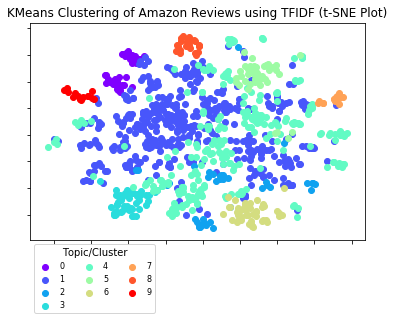

In [9]:
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

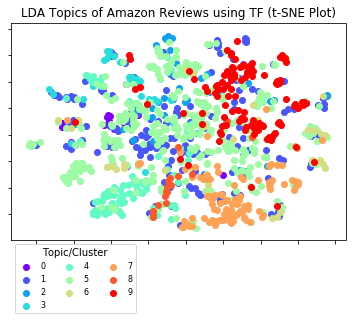

In [10]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

## Prepare data for rating prediction
The previous steps allowed us to understand how the data is structured, but it doesn't let us understand what drives positive or negative reviews. In the next steps, we look at the words within reviews to build a predictive scoring model. 

When training these types of models, overfitting can occur where we become very good at predicting our sample data, but fail to predict on new data. To avoid this, we split the data 70%/30% where we reserve the 30% for gauging our final accuracy.

We will build 3 models. One that predicts low, one that predicts high, and one that predicts neutral. For each review, we run it against all three models. The model that scores the highest will tell us which kind of review it likely is.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, data['bucket'], test_size=0.3)

## Calculate model accuracies
We try 3 different approaches to building the review predictions: Logistic Regression, Naive Bayes, and Support Vector Machines. We also try a final approach that does a combined "vote" of all three models. This means we are actually building (4 approaches) x (3 ratings) = 12 total models. Since we have limited data, we will use cross-validation to split the data 10 ways and measure accuracy in an unbiased way.

The accuracy % are printed below for each model.

In [12]:
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

Model accuracy predictions

LR model (low rating): 76.9%
LR model (neutral rating): 69.3%
LR model (high rating): 78.1%

SVM model (low rating): 75.2%
SVM model (neutral rating): 65.9%
SVM model (high rating): 77.8%

NB model (low rating): 70.5%
NB model (neutral rating): 66.7%
NB model (high rating): 70.0%

COMBINED model (low rating): 76.5%
COMBINED model (neutral rating): 69.0%
COMBINED model (high rating): 78.1%



/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Training the model of choice
All models seem to have done roughly the same on low and neutral rating reviews. SVM seems to have given better performance for our 4-5 star reviews. There is definitely room for improvement. The distribution of the stratified raiting buckets were 33% each. 

If we guessed each review's status at random, that would be our % likelihood of guessing correct. Our three models show quite an improvement over random guessing, but still opportunity to improve. There are lots of ways to tweak the prior steps to get a better result. 
- We didn't tweak any parameters in either the TF step or the modeling step
- Neg/Pos keywords might vary by topic so we might do this for one cluster at a time
- Maybe nouns don't provide much insight and we are better off removing them
- "great" and "not great" have opposite meanings so maybe we should have included 2-grams

The list goes on, but I think you get the idea. The next steps just assume we are happy with our logistic regression model.

In [13]:
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

## Plot the results
The following three charts show the result of our Logistic Regression model. We show the top 12 words **negatively associated (red)** with that review model, and the top 12 words **positively associated (green)** with that review model. Roughly speaking, the values indiciate how much more likely or unlikely a review is to be low, neutral, high given the # of times that word occurs in the review.

In the first example, "review" has a very high likelihood of predicting a low review. Remember that words are stemmed so "easi" could refer to words like "easy, easier, easiest". We clearly see negative words associated with our negative model, and positive words with our positive model. Interestingly, the neutral reviews have words I'd consider as being unsure.


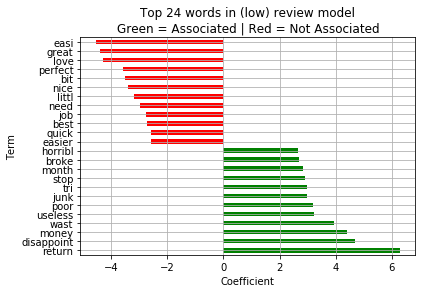

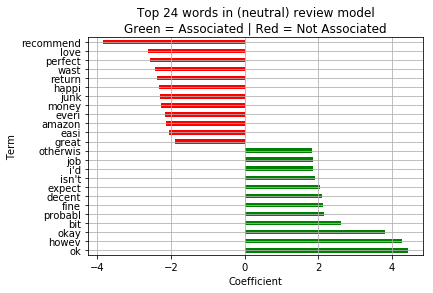

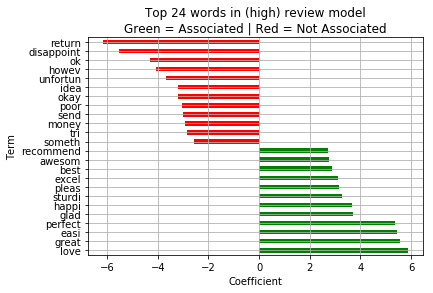

In [14]:
%matplotlib inline

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

n_terms = 12
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=cat[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)


## Test output
To put it altogether, below is a test function which allows you to supply your own review to see how well the model will predict it's rating. For simplicity, I stuck with the logistic regression model and only allow for one review at a time. 

The program uses the stored TFIDF matrix to tokenize and transform our new review which is then fed to all three of our logistic regression models. Each model has an independent assessment of how likely it is that our review is a positive hit. You could set some sort of threshold or take the model with the higest likelihood to make your determination.

In [15]:
def test_review(text):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=lr_m[m].predict_proba(test_new)[0][1]))

In [16]:
test_review('I bought these knives last week. I immediately returned these when they arrived damaged.')

Review text: "I bought these knives last week. I immediately returned these when they arrived damaged."

Model Predction
Model (low): 90.7%
Model (neutral): 7.7%
Model (high): 4.4%


In [17]:
test_review('This is the best toaster oven I have ever owned! I am glad I bought it.')

Review text: "This is the best toaster oven I have ever owned! I am glad I bought it."

Model Predction
Model (low): 9.3%
Model (neutral): 7.9%
Model (high): 90.1%
